# This file is for creating the test accuracies of the varying models

In [1]:
# Imports
import sys
import pandas as pd
import numpy as np
from rfgap import RFGAP


# Get the data
sys.path.insert(0, '/yunity/arusty/PF-GAP')

static2024 = pd.read_csv('../data/static2024.csv')
static2023 = pd.read_csv('../data/static2023.csv')
static2022 = pd.read_csv('../data/static2022.csv')
static2025 = pd.read_csv('../data/static2025.csv')
time_series = np.array(pd.read_csv('../data/time_series.csv'))
labels = pd.read_csv('../data/labels.csv')
labels = np.array(labels).flatten()


from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test, static2023_train, static2023_test, static2024_train, static2024_test = train_test_split(time_series, 
labels, static2023, static2024, test_size=0.2, random_state=42)


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
import pandas as pd


def determine_static(fold):
    if fold < 2:
        static_train = static2022
        static_test = static2023
    elif fold < 4:
        static_train = static2023
        static_test = static2024
    else:
        static_train = static2024
        static_test = static2025

    return np.array(static_train), np.array(static_test)

def get_cross_validation_results(get_predictions_method):
    # Set up cross-validation
    skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

    results = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(time_series, labels)):
        print(f"Fold {fold + 1}/{skf.n_splits}: {len(train_idx)} train samples, {len(test_idx)} test samples")
        # Split data
        X_train, X_test = time_series[train_idx], time_series[test_idx]
        y_train, y_test = labels[train_idx], labels[test_idx]

        
        static_train, static_test = determine_static(fold)

        y_pred = get_predictions_method(X_train, y_train, X_test, static_train[train_idx], static_test[test_idx])
        
        
        # RF metrics
        rf_f1 = f1_score(y_test, y_pred, average='weighted')
        rf_recall = recall_score(y_test, y_pred, average='weighted')
        rf_precision = precision_score(y_test, y_pred, average='weighted')
        rf_acc = accuracy_score(y_test, y_pred)
        
        results.append({
            'fold': fold,
            'train_idx': train_idx,
            'test_idx': test_idx,
            'rf_f1': rf_f1,
            'rf_recall': rf_recall,
            'rf_precision': rf_precision,
            'rf_accuracy': rf_acc
        })

    # Convert results to DataFrame
    return pd.DataFrame(results)




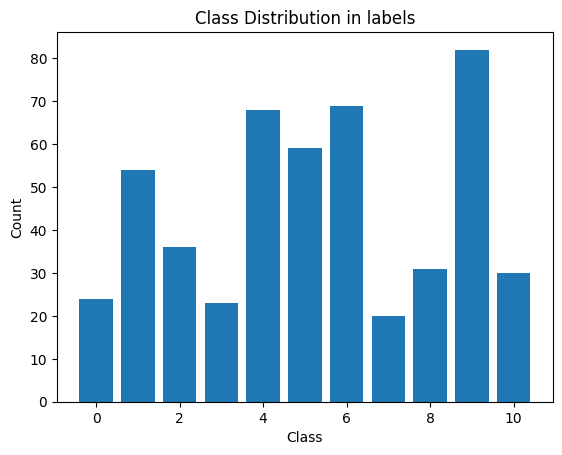

In [ ]:
# Class distribuation
import matplotlib.pyplot as plt

unique, counts = np.unique(labels, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in labels')
plt.show()

# RF - Rocket

In [2]:
from RFGAP_Rocket.RFGAP_Rocket import RFGAP_Rocket
rocket = RFGAP_Rocket(prediction_type = "classification", rocket = "Multi",
                         n_kernels=512)
rocket.fit(X_train, y_train, static2023_train, weights = None)
pred = rocket.predict(X_test, static2024_test)

score = (pred == y_test).mean()
print(f"Accuracy: {score:.2f}")


Accuracy: 0.54


In [3]:
def get_rocket_pred(X_train, y_train, X_test, static_train, static_test):
    rocket = RFGAP_Rocket(prediction_type = "classification", rocket = "Multi",
                         n_kernels=512)
    
    rocket.fit(X_train, y_train, static_train, weights = None)
    return rocket.predict(X_test, static_test)



In [4]:
get_cross_validation_results(get_rocket_pred)

/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

,fold,train_idx,test_idx,rf_f1,rf_recall,rf_precision,rf_accuracy
0,0,"[0, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...","[1, 2, 5, 21, 23, 28, 31, 36, 63, 75, 85, 98, ...",0.437647,0.457831,0.446787,0.457831
1,1,"[1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[0, 4, 22, 29, 30, 39, 42, 48, 50, 53, 55, 65,...",0.467416,0.493976,0.510756,0.493976
2,2,"[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15...","[7, 13, 18, 20, 35, 44, 60, 61, 70, 78, 91, 96...",0.541923,0.554217,0.552932,0.554217
3,3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15...","[9, 11, 17, 25, 27, 34, 37, 38, 40, 46, 51, 57...",0.499335,0.518072,0.535049,0.518072
4,4,"[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14...","[8, 16, 24, 26, 33, 47, 52, 54, 56, 71, 73, 74...",0.441403,0.475610,0.533573,0.475610
5,5,"[0, 1, 2, 4, 5, 7, 8, 9, 11, 13, 16, 17, 18, 2...","[3, 6, 10, 12, 14, 15, 19, 32, 41, 43, 45, 49,...",0.433894,0.439024,0.488796,0.439024


# RDST TRIALS

In [2]:
from RDST.rdst import RDST_GAP

rdst = RDST_GAP(save_transformed_data = True)
rdst.fit(X_train, y_train, static = static2023_train)
pred = rdst.predict(X_test, static = static2024_test)
score = (pred == y_test).mean()
print(f"Accuracy: {score:.2f}")

Accuracy: 0.58


In [4]:
def get_rdst_pred(X_train, y_train, X_test, static_train, static_test):
    rdst = RDST_GAP(save_transformed_data = True)
    rdst.fit(X_train, y_train, static = static_train)
    return rdst.predict(X_test, static = static_test)
    

get_cross_validation_results(get_rdst_pred)

Fold 1/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 4/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 5/6: 414 train samples, 82 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 6/6: 414 train samples, 82 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,fold,train_idx,test_idx,rf_f1,rf_recall,rf_precision,rf_accuracy
0,0,"[0, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...","[1, 2, 5, 21, 23, 28, 31, 36, 63, 75, 85, 98, ...",0.576869,0.578313,0.654929,0.578313
1,1,"[1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[0, 4, 22, 29, 30, 39, 42, 48, 50, 53, 55, 65,...",0.566219,0.578313,0.605185,0.578313
2,2,"[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15...","[7, 13, 18, 20, 35, 44, 60, 61, 70, 78, 91, 96...",0.546735,0.566265,0.569720,0.566265
3,3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15...","[9, 11, 17, 25, 27, 34, 37, 38, 40, 46, 51, 57...",0.637985,0.650602,0.697791,0.650602
4,4,"[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14...","[8, 16, 24, 26, 33, 47, 52, 54, 56, 71, 73, 74...",0.561358,0.597561,0.622804,0.597561
5,5,"[0, 1, 2, 4, 5, 7, 8, 9, 11, 13, 16, 17, 18, 2...","[3, 6, 10, 12, 14, 15, 19, 32, 41, 43, 45, 49,...",0.586713,0.597561,0.647129,0.597561


# QUANT TRIALS

In [2]:
from QGAP.qgap import QGAP
qgap= QGAP(matrix_type="dense")

qgap.fit(X_train,y_train, static = static2023_train)
pred = qgap.predict(X_test, static = static2024_test)
score = (pred == y_test).mean()
print(f"Accuracy: {score:.2f}")

Accuracy: 0.59


In [3]:
def get_qgap_pred(X_train, y_train, X_test, static_train, static_test):
    qgap = QGAP(matrix_type="dense")
    qgap.fit(X_train, y_train, static = static_train)
    return qgap.predict(X_test, static = static_test)
    

get_cross_validation_results(get_qgap_pred)

Fold 1/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 4/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 5/6: 414 train samples, 82 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 6/6: 414 train samples, 82 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,fold,train_idx,test_idx,rf_f1,rf_recall,rf_precision,rf_accuracy
0,0,"[0, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...","[1, 2, 5, 21, 23, 28, 31, 36, 63, 75, 85, 98, ...",0.529739,0.542169,0.575636,0.542169
1,1,"[1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[0, 4, 22, 29, 30, 39, 42, 48, 50, 53, 55, 65,...",0.573828,0.602410,0.606053,0.602410
2,2,"[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15...","[7, 13, 18, 20, 35, 44, 60, 61, 70, 78, 91, 96...",0.681893,0.698795,0.698289,0.698795
3,3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15...","[9, 11, 17, 25, 27, 34, 37, 38, 40, 46, 51, 57...",0.572917,0.590361,0.604100,0.590361
4,4,"[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14...","[8, 16, 24, 26, 33, 47, 52, 54, 56, 71, 73, 74...",0.588058,0.609756,0.626150,0.609756
5,5,"[0, 1, 2, 4, 5, 7, 8, 9, 11, 13, 16, 17, 18, 2...","[3, 6, 10, 12, 14, 15, 19, 32, 41, 43, 45, 49,...",0.552714,0.573171,0.579343,0.573171
